First off, just read the data

In [1]:
import pandas as pd
# import seaborn as sns
import numpy as np
import yaml

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
df = pd.read_csv("results.csv")

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
df

,App,Key,Logical Lines of Code,Halstead Volume,Halstead Difficulty,Halstead Effort,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99,Number of Words
0,insurance_claims,fbp_app_min,210,543.658677,6.210526,3376.406518,43.30,1.93478,6,0.424242,4,846
1,insurance_claims,fbp_app_data,239,610.424232,6.190476,3778.816672,40.80,2.12500,8,0.657143,5,974
2,insurance_claims,fbp_app_ml,263,543.658677,6.848214,3723.091116,38.46,2.29412,6,0.918919,7,1056
3,insurance_claims,soa_app_min,250,383.285425,6.000000,2299.712549,46.22,1.36364,2,1.166670,4,1094
4,insurance_claims,soa_app_data,285,463.722322,7.000000,3246.056251,44.19,1.41667,2,1.176470,4,1247
5,insurance_claims,soa_app_ml,356,675.754180,7.101449,4798.834030,38.49,1.38462,2,1.487180,9,1508
6,mblogger,fbp_app_min,174,155.114511,2.000000,310.229021,43.55,1.81081,5,0.307692,2,541
7,mblogger,fbp_app_data,222,230.817736,2.500000,577.044339,37.67,1.91304,7,0.312500,2,694
8,mblogger,fbp_app_ml,273,331.413717,3.000000,994.241152,33.22,1.90909,5,0.342105,3,858
9,mblogger,soa_app_min,240,213.673439,3.000000,641.020318,46.93,1.75000,3,1.142860,3,1002


In [5]:
df.describe()

,Logical Lines of Code,Halstead Volume,Halstead Difficulty,Halstead Effort,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99,Number of Words
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,295.333333,541.953968,4.737748,2884.614710,37.679167,1.939183,4.625000,0.885616,4.750000,1154.291667
std,107.430328,338.328774,1.699629,2265.812068,6.395032,0.326757,2.039022,0.481405,3.068068,500.530195
min,158.000000,155.114511,2.000000,310.229021,25.420000,1.363640,2.000000,0.250000,1.000000,507.000000
25%,234.750000,315.640000,3.143617,979.071566,33.250000,1.724997,2.750000,0.427489,3.000000,855.000000
50%,269.500000,438.380182,4.532790,2100.084724,38.605000,1.923910,5.000000,0.827881,4.000000,1075.000000
75%,331.000000,639.195049,6.195489,4033.821012,43.362500,2.246758,6.250000,1.229912,7.000000,1271.500000
max,596.000000,1417.492568,7.101449,8295.166509,46.930000,2.444440,8.000000,1.694920,12.000000,2486.000000


In [6]:
apps = df["App"].unique().tolist()
metrics = df.columns[2:].tolist()

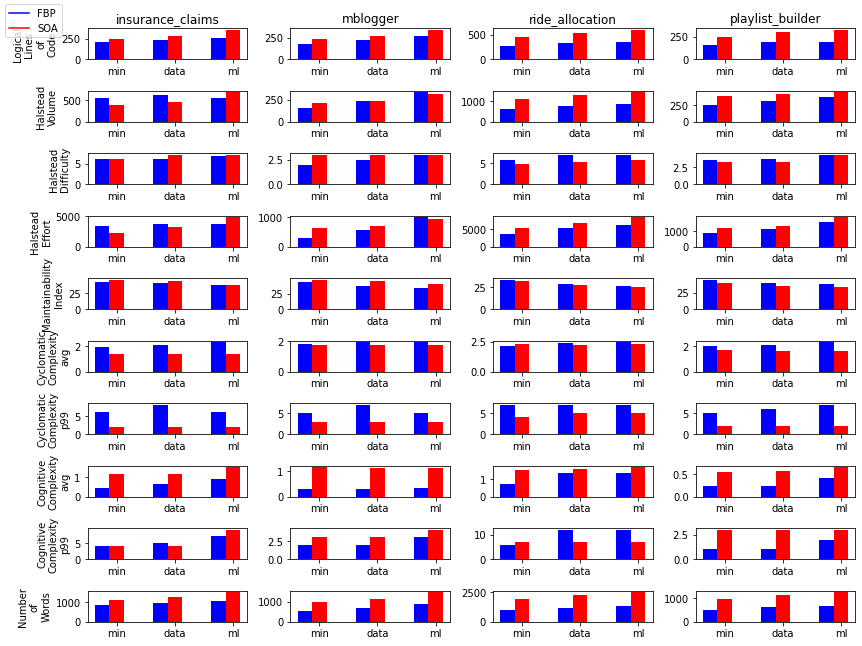

In [7]:
fig, axes = plt.subplots(nrows=len(metrics), ncols=len(apps), figsize=(12, 9))

for ax, app in zip(axes[0], apps):
    ax.set_title(app);

for ax, metric in zip(axes[:,0], metrics):
    ax.set_ylabel(metric.replace(' ', "\n"), size=10);

for ir, metric in enumerate(metrics):
    for ic, app in enumerate(apps):
        values = df[df["App"] == app][["Key", metric]]
        values_fbp = values.loc[values['Key'].isin(['fbp_app_min','fbp_app_data','fbp_app_ml'])]
        values_soa = values.loc[values['Key'].isin(['soa_app_min','soa_app_data','soa_app_ml'])]
        labels = [k[k.rfind('_')+1:] for k in values_fbp["Key"]]
        X = np.arange(len(values_fbp))
        axes[ir][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[ir][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );
        
        

fig.tight_layout();


legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]

fig.legend(handles=legend_elements, loc='upper left')

plt.show();

Some metrics scale with the size of the codebase, while others don't. For the former we calculate change in percentages, for the latter in absolute values.

In [8]:
absolute_diff_metrics = [
    "Halstead Difficulty", "Maintainability Index",
    "Cyclomatic Complexity avg", "Cyclomatic Complexity p99",
    "Cognitive Complexity avg", "Cognitive Complexity p99"
]
percentage_diff_metrics = [
    "Logical Lines of Code", "Halstead Volume",
    "Halstead Effort", "Number of Words"
]

Here we calculate the differences and re-organize the dataframe a bit.

In [9]:
all_dfs = []
for i in range(0, df.shape[0], 3):
    df_change = pd.concat([
        df.iloc[i:i+3, 2:][percentage_diff_metrics].pct_change(),
        df.iloc[i:i+3, 2:][absolute_diff_metrics].diff(),
    ], axis=1)
    df_change.insert(0, "App", df["App"])
    df_change = df_change.iloc[1: , :]
    df_change.insert(1, "Keys", ["min/data", "data/ml"])
    all_dfs.append(df_change)

fbp_dfs = [all_dfs[0], all_dfs[2], all_dfs[4], all_dfs[6]]
soa_dfs = [all_dfs[1], all_dfs[3], all_dfs[5], all_dfs[7]]

for fbp_df in fbp_dfs:
    fbp_df.insert(1, "Paradigm", ["fbp", "fbp"])
for soa_df in soa_dfs:
    soa_df.insert(1, "Paradigm", ["soa", "soa"])

all_changes_df = pd.concat(fbp_dfs + soa_dfs, axis=0)
all_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
1,insurance_claims,fbp,min/data,0.138095,0.122808,0.119183,0.151300,-0.020050,-2.50,0.19022,2.0,0.232901,1.0
2,insurance_claims,fbp,data/ml,0.100418,-0.109376,-0.014747,0.084189,0.657738,-2.34,0.16912,-2.0,0.261776,2.0
7,mblogger,fbp,min/data,0.275862,0.488047,0.860059,0.282810,0.500000,-5.88,0.10223,2.0,0.004808,0.0
8,mblogger,fbp,data/ml,0.229730,0.435824,0.722989,0.236311,0.500000,-4.45,-0.00395,-2.0,0.029605,1.0
13,ride_allocation,fbp,min/data,0.171533,0.223463,0.451884,0.207113,1.094453,-4.47,0.27290,0.0,0.653398,6.0
14,ride_allocation,fbp,data/ml,0.121495,0.148057,0.157376,0.126516,0.056465,-2.71,0.02339,0.0,0.009760,0.0
19,playlist_builder,fbp,min/data,0.208861,0.212279,0.253336,0.226824,0.119122,-4.96,0.12941,1.0,0.000000,0.0
20,playlist_builder,fbp,data/ml,0.031414,0.170650,0.370372,0.069132,0.620393,-1.05,0.17500,1.0,0.178571,1.0
4,insurance_claims,soa,min/data,0.140000,0.209862,0.411505,0.139854,1.000000,-2.03,0.05303,0.0,0.009800,0.0
5,insurance_claims,soa,data/ml,0.249123,0.457239,0.478358,0.209302,0.101449,-5.70,-0.03205,0.0,0.310710,5.0


In the resulting dataframe columns contain measured changes for different apps. "Keys" column signifies which pair is considered. E.g. "min/data" means that changes are measured for transition between "min" and "data" stages.

['Logical Lines of Code', 'Halstead Volume', 'Halstead Difficulty', 'Halstead Effort', 'Maintainability Index', 'Cyclomatic Complexity avg', 'Cyclomatic Complexity p99', 'Cognitive Complexity avg', 'Cognitive Complexity p99', 'Number of Words']


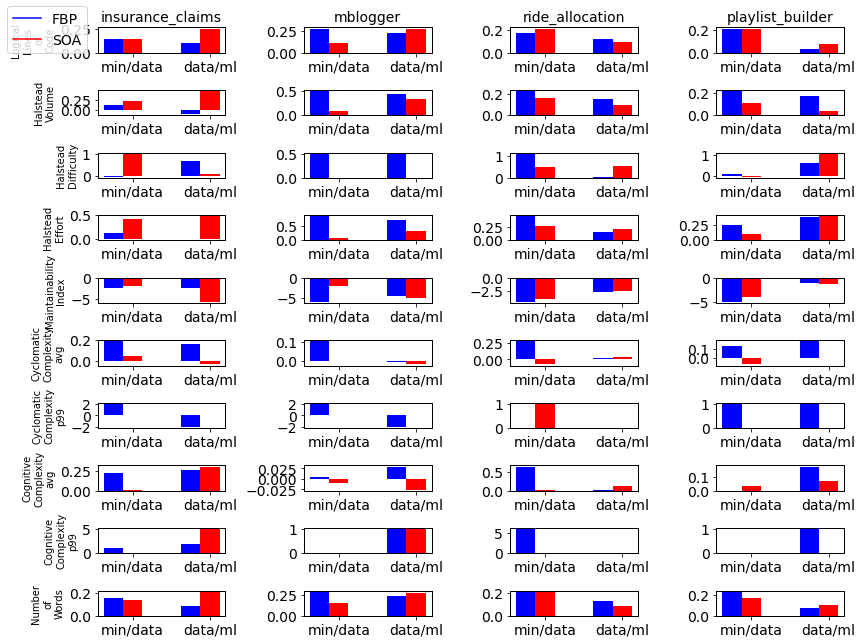

In [39]:
apps = all_changes_df["App"].unique().tolist()
metrics = df.columns[2:].tolist()

print(metrics)

fig, axes = plt.subplots(nrows=len(metrics), ncols=len(apps), figsize=(12, 9))

for ax, app in zip(axes[0], apps):
    ax.set_title(app);

for ax, metric in zip(axes[:,0], metrics):
    ax.set_ylabel(metric.replace(' ', "\n"), size=10);

for ir, metric in enumerate(metrics):
    for ic, app in enumerate(apps):
        values = all_changes_df[all_changes_df["App"] == app][["Paradigm", "Keys", metric]]
        values_fbp = values.loc[values['Paradigm'].isin(['fbp'])]
        values_soa = values.loc[values['Paradigm'].isin(['soa'])]
        labels = [k[k.rfind('_')+1:] for k in values_fbp["Paradigm"]]
        X = np.arange(len(values_fbp))
        colors = ['b' if k == 'fbp' else 'r' for k in values["Paradigm"]]
        labels = values_fbp["Keys"]
        axes[ir][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[ir][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );

fig.tight_layout();


legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]

fig.legend(handles=legend_elements, loc='upper left');

plt.show();

Let's look at individual stages, or rather pairs of stages.

In [40]:
min_data_changes_df = all_changes_df[all_changes_df["Keys"] == 'min/data']
data_ml_changes_df = all_changes_df[all_changes_df["Keys"] == 'data/ml']

In [41]:
min_data_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
1,insurance_claims,fbp,min/data,0.138095,0.122808,0.119183,0.151300,-0.020050,-2.50,0.19022,2.0,0.232901,1.0
7,mblogger,fbp,min/data,0.275862,0.488047,0.860059,0.282810,0.500000,-5.88,0.10223,2.0,0.004808,0.0
13,ride_allocation,fbp,min/data,0.171533,0.223463,0.451884,0.207113,1.094453,-4.47,0.27290,0.0,0.653398,6.0
19,playlist_builder,fbp,min/data,0.208861,0.212279,0.253336,0.226824,0.119122,-4.96,0.12941,1.0,0.000000,0.0
4,insurance_claims,soa,min/data,0.140000,0.209862,0.411505,0.139854,1.000000,-2.03,0.05303,0.0,0.009800,0.0
10,mblogger,soa,min/data,0.108333,0.088795,0.088795,0.144711,0.000000,-2.15,0.00000,0.0,-0.009530,0.0
16,ride_allocation,soa,min/data,0.215247,0.158409,0.277145,0.204927,0.492901,-3.87,-0.07440,1.0,0.026260,0.0
22,playlist_builder,soa,min/data,0.201581,0.108873,0.102718,0.167689,-0.017813,-3.93,-0.06364,0.0,0.034946,0.0


In [42]:
data_ml_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
2,insurance_claims,fbp,data/ml,0.100418,-0.109376,-0.014747,0.084189,0.657738,-2.34,0.16912,-2.0,0.261776,2.0
8,mblogger,fbp,data/ml,0.229730,0.435824,0.722989,0.236311,0.500000,-4.45,-0.00395,-2.0,0.029605,1.0
14,ride_allocation,fbp,data/ml,0.121495,0.148057,0.157376,0.126516,0.056465,-2.71,0.02339,0.0,0.009760,0.0
20,playlist_builder,fbp,data/ml,0.031414,0.170650,0.370372,0.069132,0.620393,-1.05,0.17500,1.0,0.178571,1.0
5,insurance_claims,soa,data/ml,0.249123,0.457239,0.478358,0.209302,0.101449,-5.70,-0.03205,0.0,0.310710,5.0
11,mblogger,soa,data/ml,0.278195,0.337598,0.337598,0.270270,0.000000,-4.85,-0.01667,0.0,-0.025220,1.0
17,ride_allocation,soa,data/ml,0.099631,0.098153,0.212133,0.081340,0.550276,-2.45,0.03463,0.0,0.113100,0.0
23,playlist_builder,soa,data/ml,0.078947,0.040904,0.386138,0.105079,1.058511,-1.31,0.00000,0.0,0.074562,0.0


Let's try to put absolute and relative plots together.

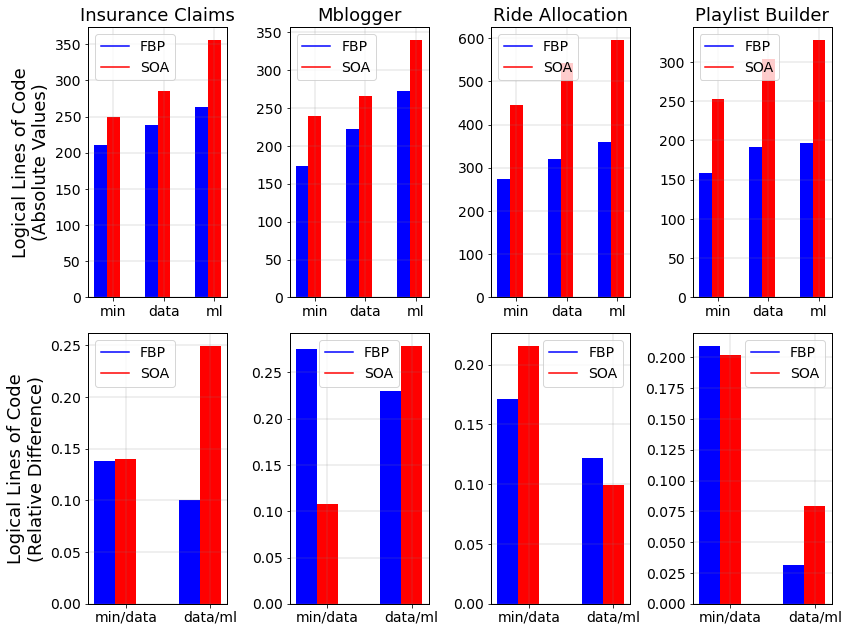

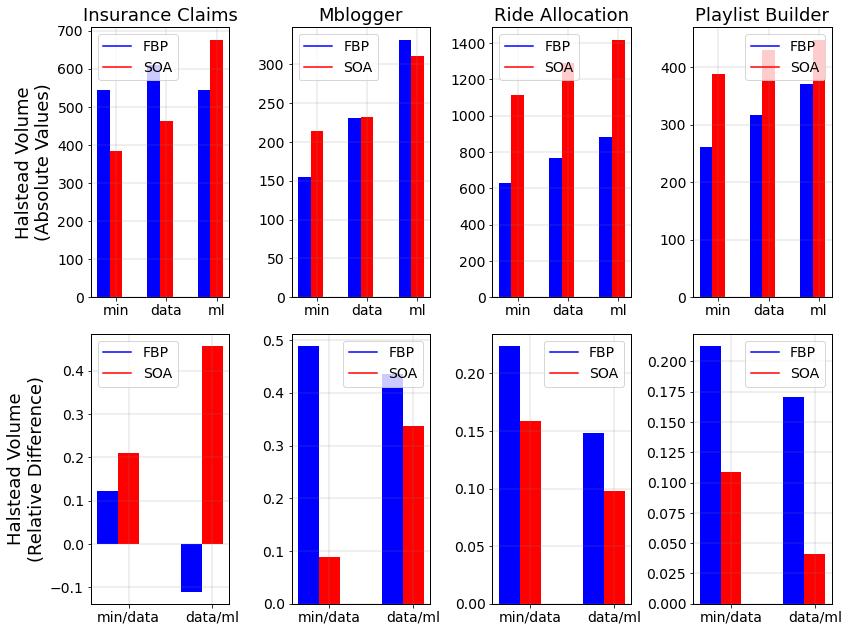

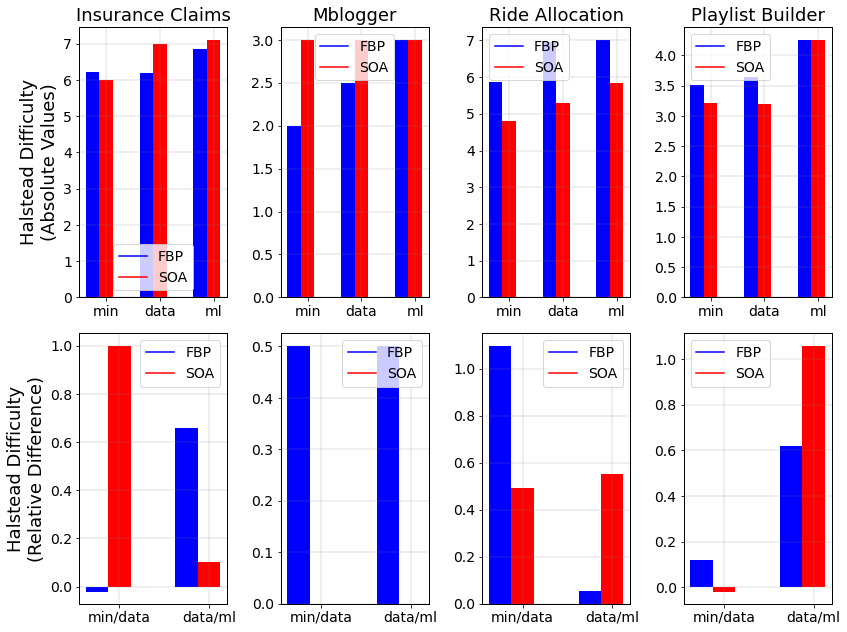

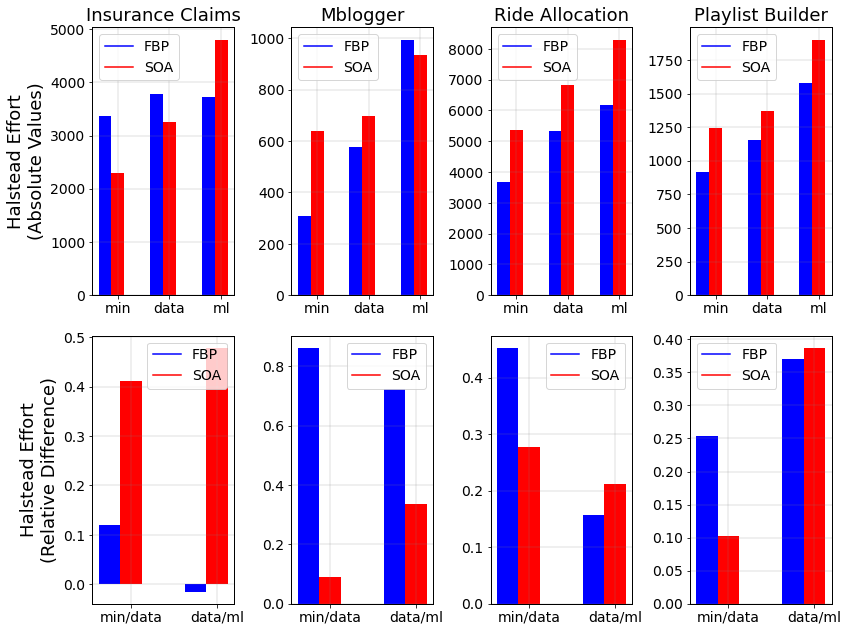

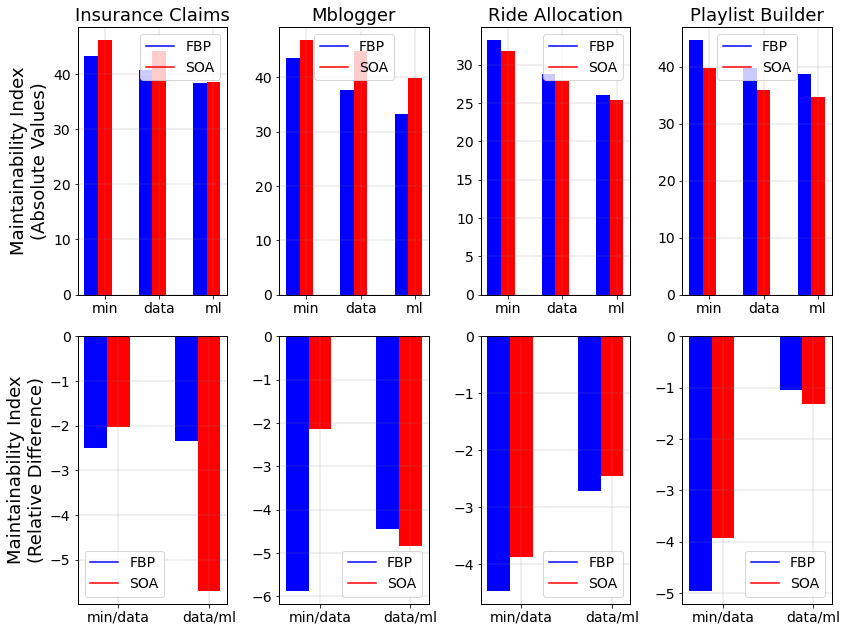

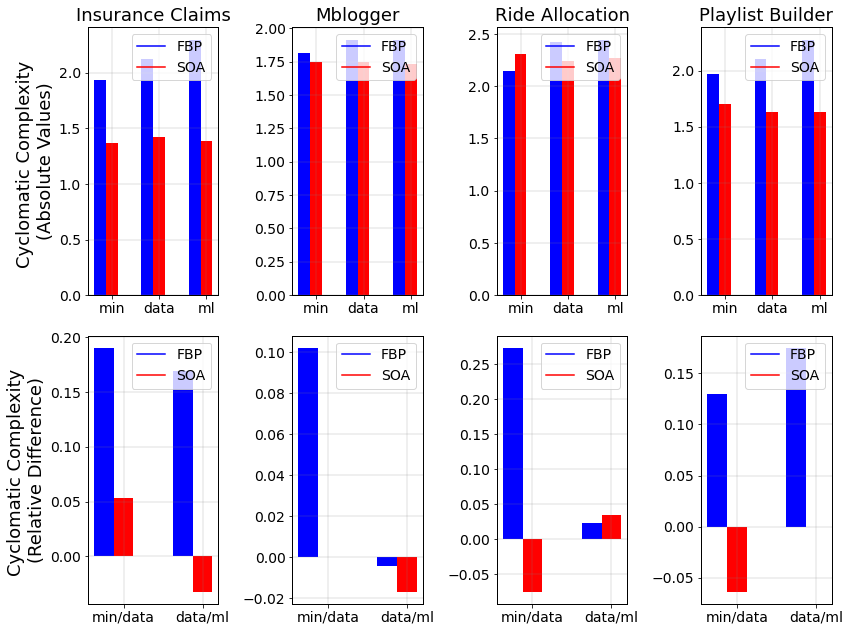

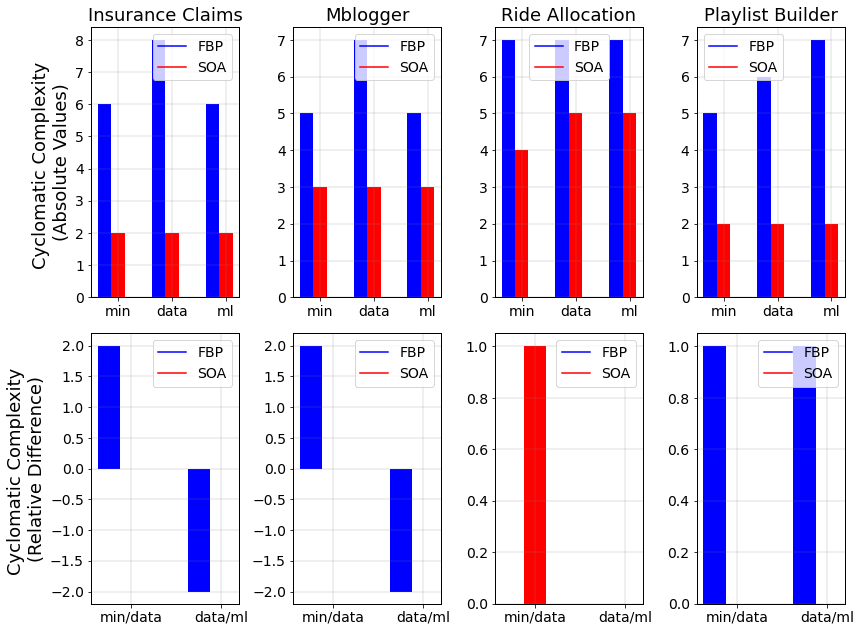

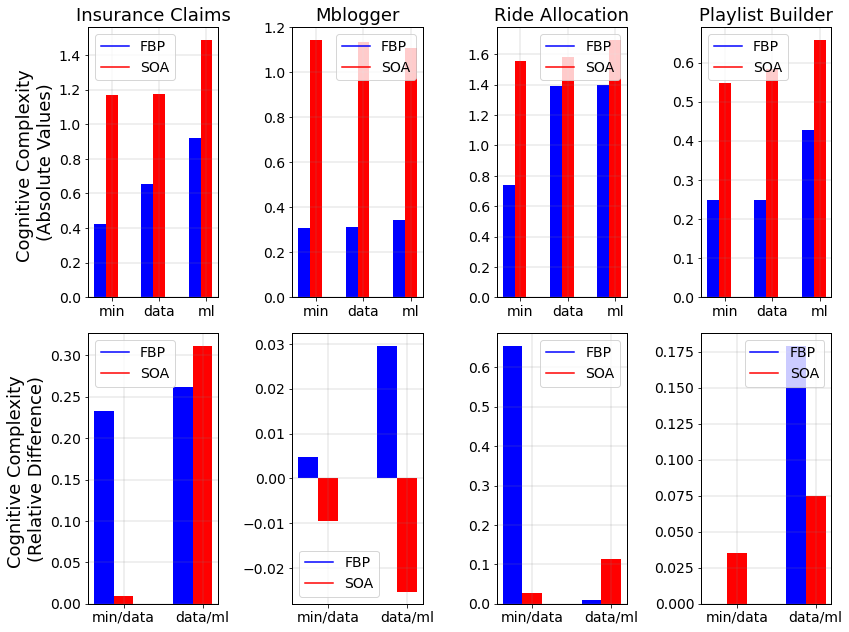

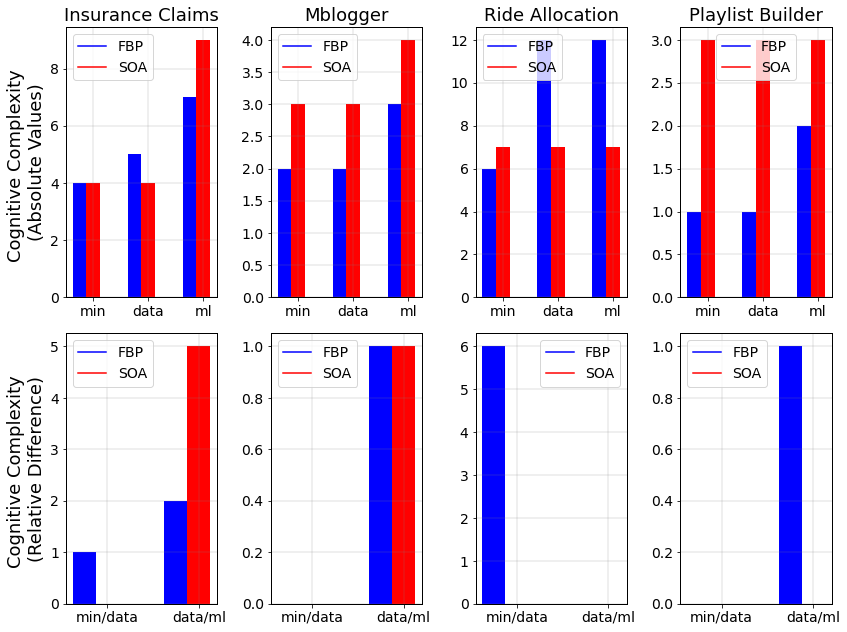

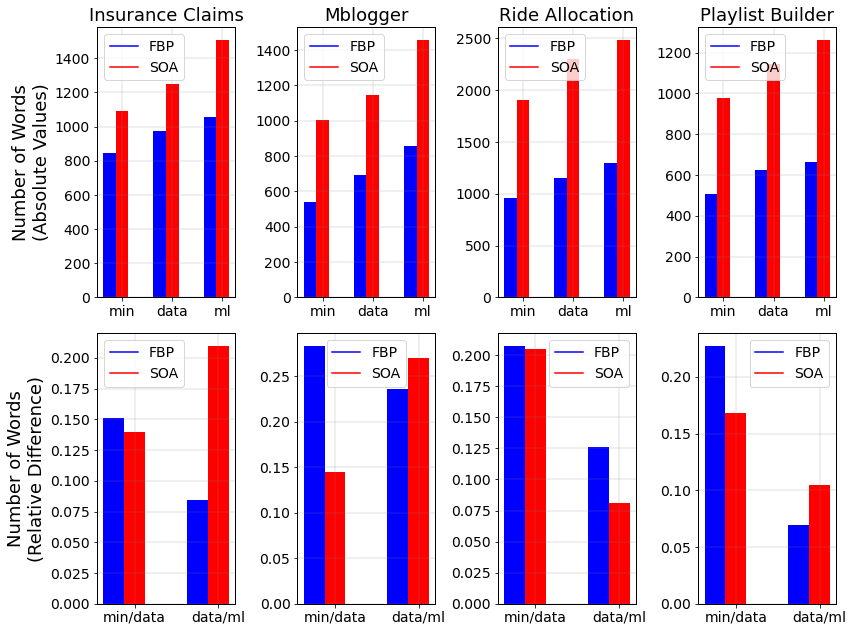

In [43]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
LARGE_SIZE = 22
HEAD_WIDTH = 1
HEAD_LEN = 1
FAMILY = "Times New Roman"
plt.rc("font", size=SMALL_SIZE, family=FAMILY)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=1.0)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=LARGE_SIZE)

apps = df["App"].unique().tolist();
metrics = df.columns[2:].tolist();

for metric in metrics:
    fig, axes = plt.subplots(nrows=2, ncols=len(apps),figsize=(12, 9));
    for ic, app in enumerate(apps):
        values = df[df["App"] == app][["Key", metric]];
        values_fbp = values.loc[values['Key'].isin(['fbp_app_min','fbp_app_data','fbp_app_ml'])];
        values_soa = values.loc[values['Key'].isin(['soa_app_min','soa_app_data','soa_app_ml'])];
        labels = [k[k.rfind('_')+1:] for k in values_fbp["Key"]];
        X = np.arange(len(values_fbp));
        axes[0][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[0][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );
        axes[0][0].set_ylabel(metric.replace('avg','').replace('p99','') + '\n(Absolute Values)');
        axes[0][ic].set_title(app.replace('_', ' ').title());
        legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                       Line2D([0], [0], color='r', label='SOA')];
        axes[0][ic].legend(handles=legend_elements, loc='best');
        axes[0][ic].grid(linestyle="-", linewidth="0.25", color="grey");
        
        values = all_changes_df[all_changes_df["App"] == app][["Paradigm", "Keys", metric]];
        values_fbp = values.loc[values['Paradigm'].isin(['fbp'])];
        values_soa = values.loc[values['Paradigm'].isin(['soa'])];
        labels = values_fbp["Keys"];
        X = np.arange(len(values_fbp));
        
        axes[1][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[1][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );
        axes[1][0].set_ylabel(metric.replace('avg','').replace('p99','') + '\n(Relative Difference)');
        axes[0][ic].set_title(app.replace('_', ' ').title());
        legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                       Line2D([0], [0], color='r', label='SOA')];
        axes[1][ic].legend(handles=legend_elements, loc='best');
        axes[1][ic].grid(linestyle="-", linewidth="0.25", color="grey");
        
    fig.tight_layout();
    plt.savefig('figures/' + metric.replace(' ','_').lower() + '.pdf');

plt.show(); 
    

Let's group the absolute results by stage

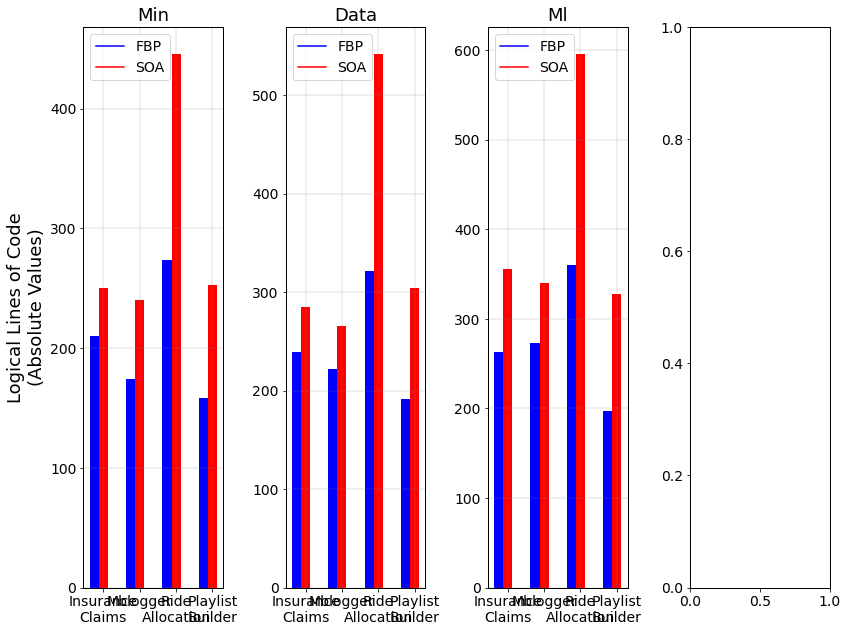

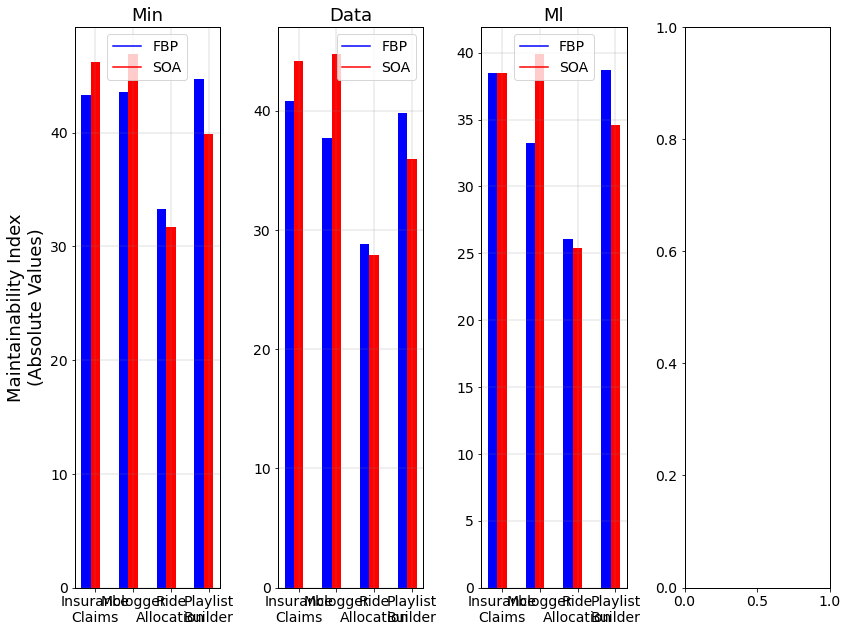

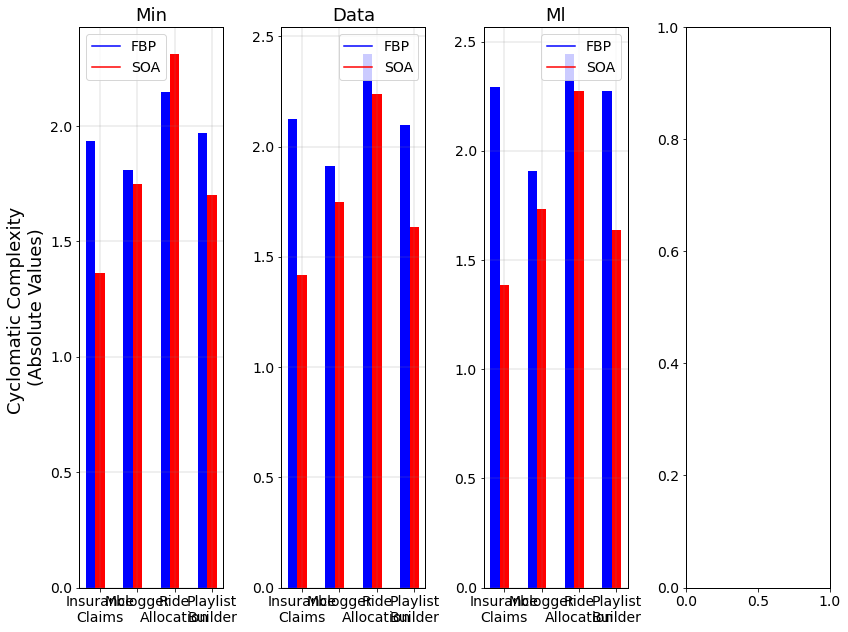

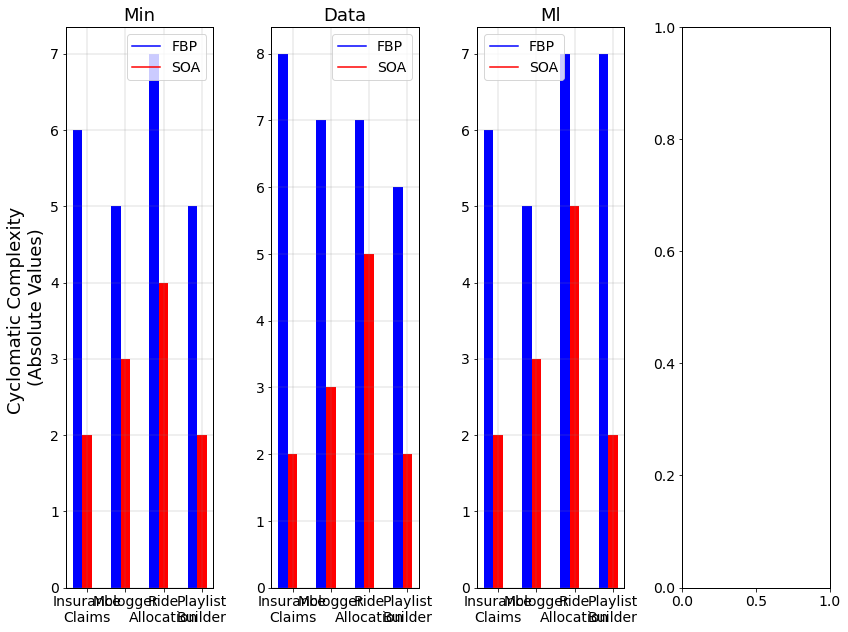

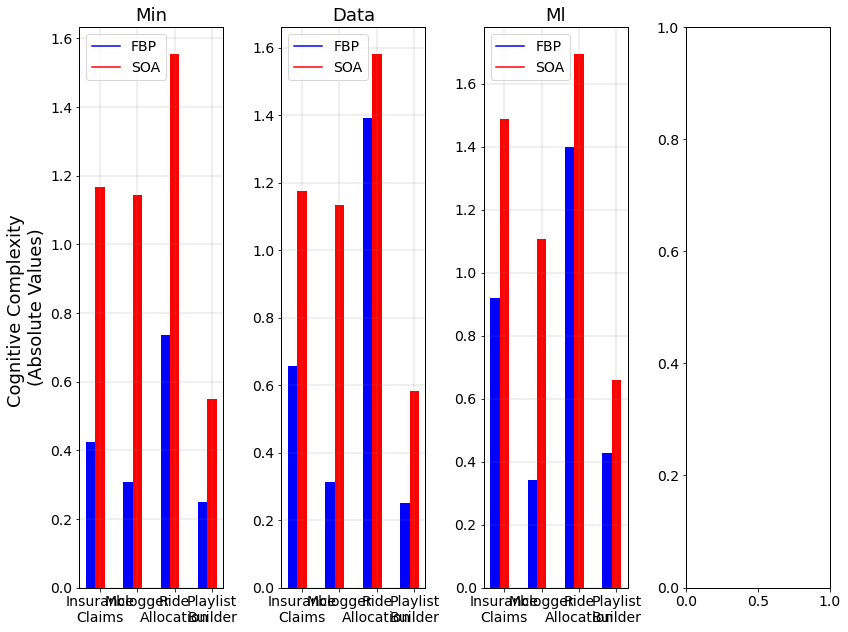

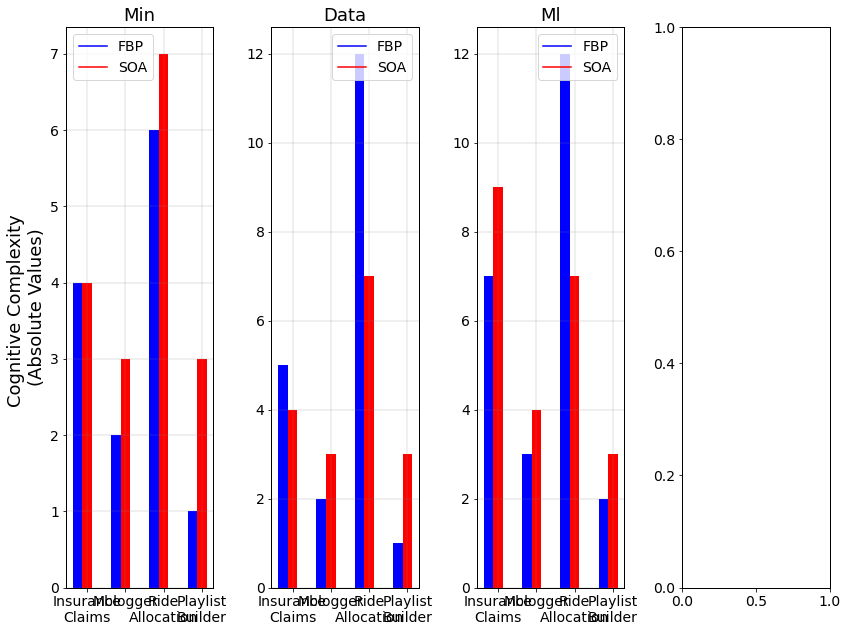

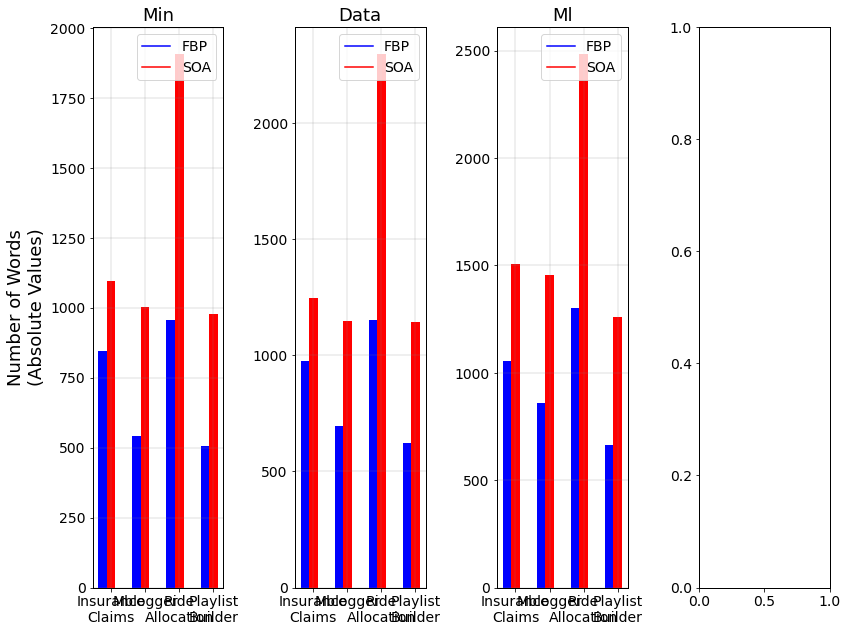

In [44]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
LARGE_SIZE = 22
HEAD_WIDTH = 1
HEAD_LEN = 1
FAMILY = "Times New Roman"
plt.rc("font", size=SMALL_SIZE, family=FAMILY)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=1.0)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=LARGE_SIZE)

apps = df["App"].unique().tolist();
stages = df["Key"].unique().tolist();
metrics = df.columns[2:].tolist();

metrics.remove('Halstead Volume');
metrics.remove('Halstead Difficulty');
metrics.remove('Halstead Effort');

for metric in metrics:
    fig, axes = plt.subplots(nrows=1, ncols=len(apps),figsize=(12, 9));
    for stage in stages:
        values = df[df["Key"] == stage][["Key", "App", metric]];
        ic = 0;
        if stage == "fbp_app_min" or stage == "soa_app_min":
            ic = 0
        if stage == "fbp_app_data" or stage == "soa_app_data":
            ic = 1
        if stage == "fbp_app_ml" or stage == "soa_app_ml":
            ic = 2
        
        labels = apps;
        labels = [app.replace("_","\n").title() for app in apps]
        X = np.arange(len(apps))
        c = 'b'
        if "soa" in stage:
            X = X + 0.25
            c = 'r'
        axes[ic].bar(
                X, values[metric], width=0.25,
                tick_label=labels, align='center', color=c
            );
        axes[0].set_ylabel(metric.replace('avg','').replace('p99','') + '\n(Absolute Values)');
        axes[ic].set_title(app.replace('_', ' ').title());
        legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                       Line2D([0], [0], color='r', label='SOA')];
        axes[ic].legend(handles=legend_elements, loc='best');
        axes[ic].grid(linestyle="-", linewidth="0.25", color="grey");
        axes[ic].set_title(stage[stage.rfind('_')+1:].title());
        
    fig.tight_layout();
    plt.savefig('figures/' + metric.replace(' ','_').lower() + '_absolute.pdf');

plt.show(); 

Let's group the relative values by stage.

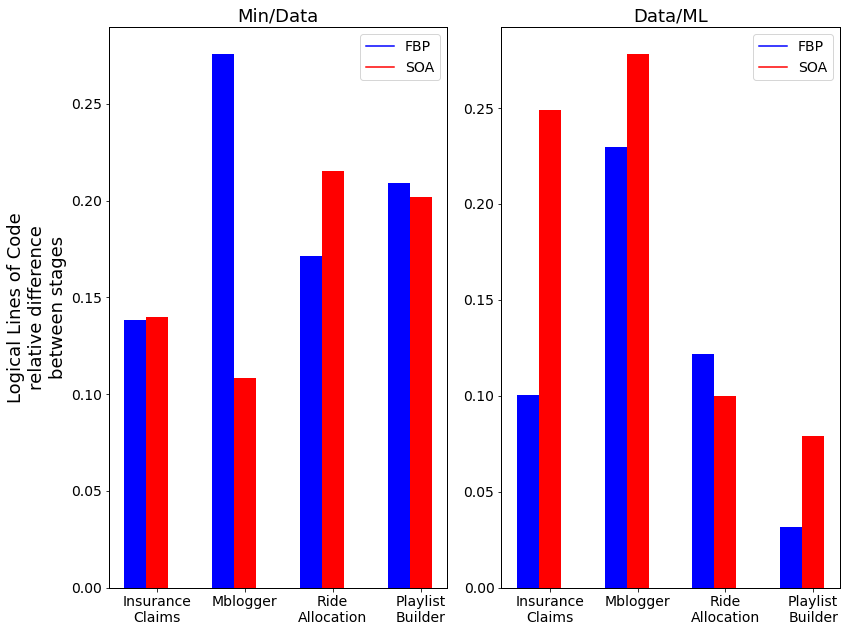

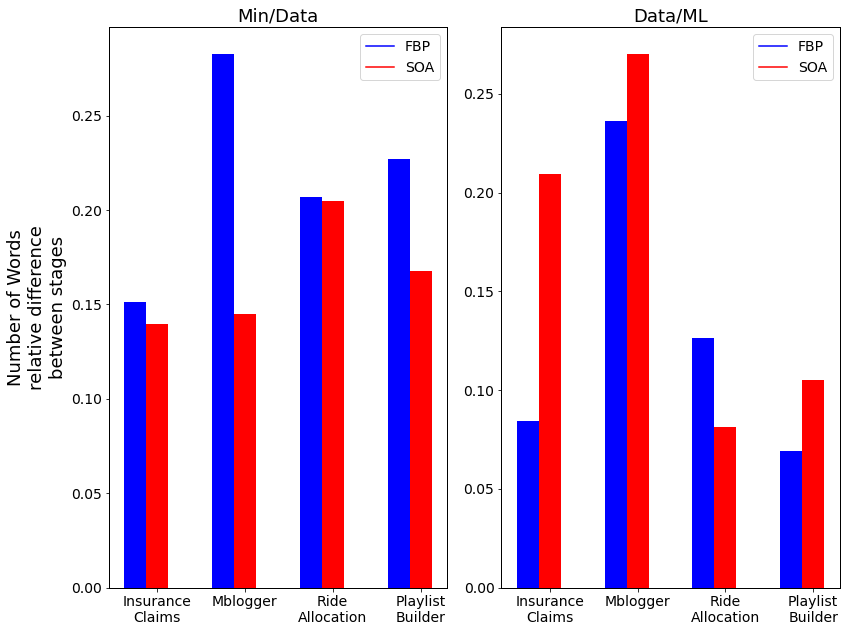

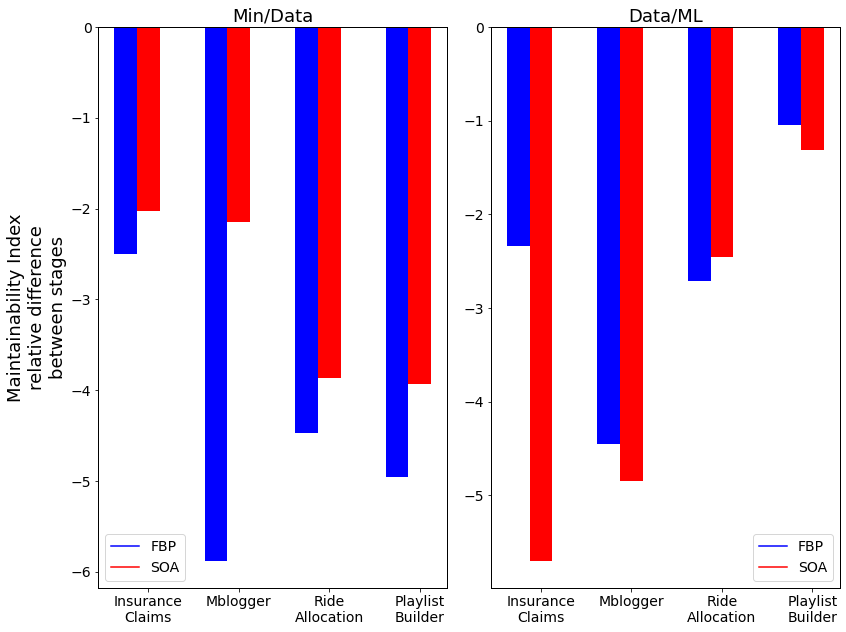

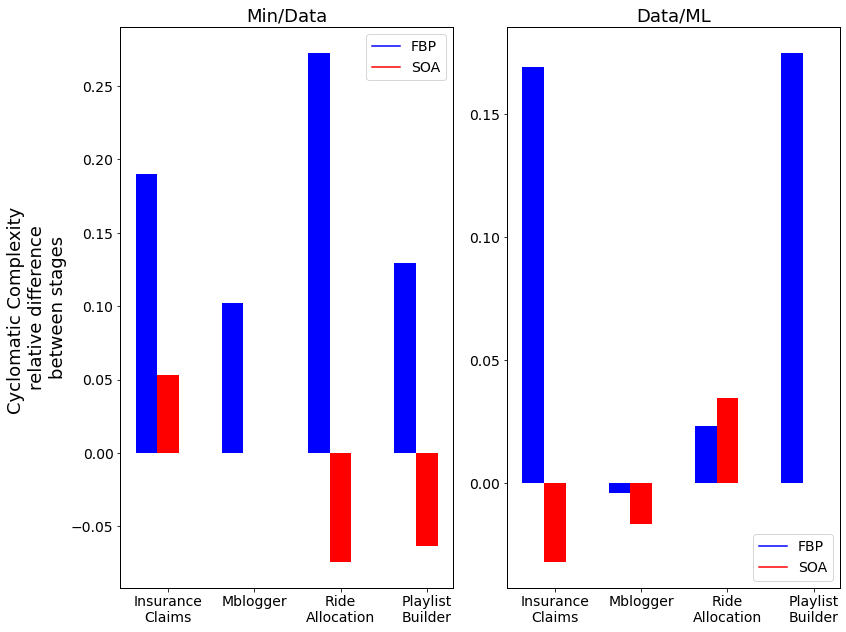

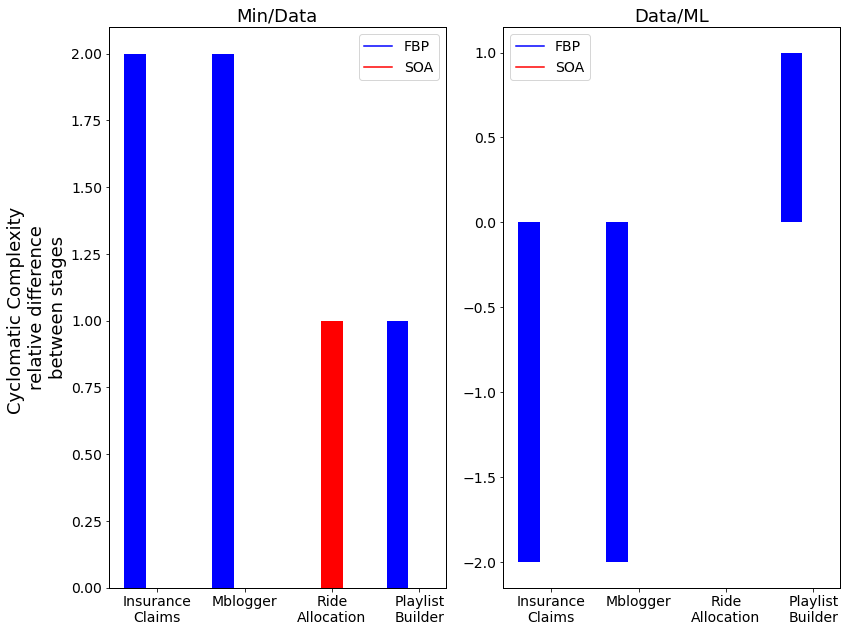

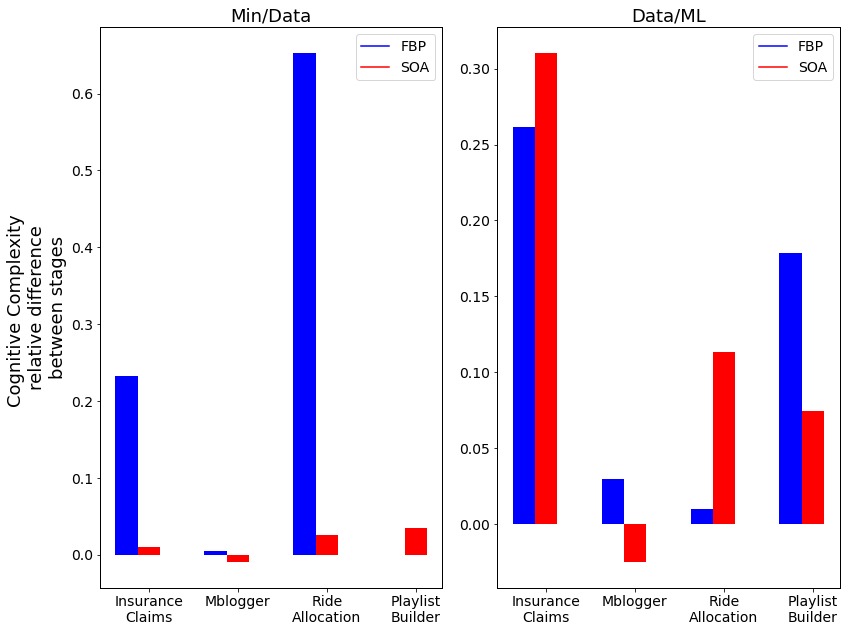

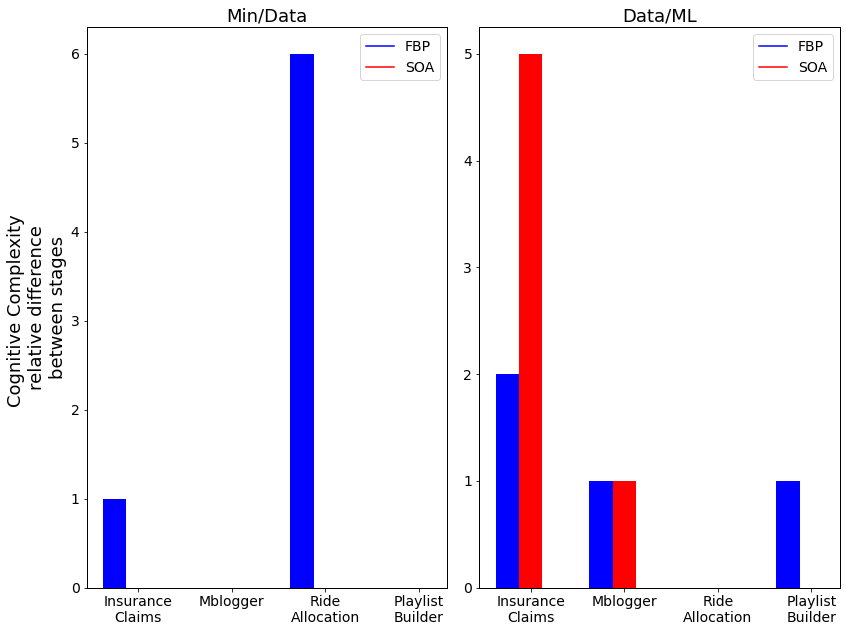

In [45]:
apps = all_changes_df["App"].unique().tolist();
stages = all_changes_df["Keys"].unique().tolist();
metrics = all_changes_df.columns[3:].tolist();

metrics.remove('Halstead Volume');
metrics.remove('Halstead Difficulty');
metrics.remove('Halstead Effort');

for metric in metrics:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 9));
    for ic, stage in enumerate(stages):
        values = all_changes_df[all_changes_df["Keys"] == stage][["Paradigm", "App", "Keys", metric]];
        values_fbp = values.loc[values['Paradigm'].isin(['fbp'])];
        values_fbp
        values_soa = values.loc[values['Paradigm'].isin(['soa'])];
        values_soa
        labels = [app.replace("_","\n").title() for app in apps]
        labels
        X = np.arange(len(apps))
        axes[ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );
        
        axes[0].set_ylabel(metric.replace('avg','').replace('p99','') + '\nrelative difference\nbetween stages');
        axes[ic].set_title(app.replace('_', ' ').title());
        legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                       Line2D([0], [0], color='r', label='SOA')];
        axes[ic].legend(handles=legend_elements, loc='best');
        axes[ic].set_title(stage[stage.rfind('_')+1:].title().replace('l','L'));
        
    fig.tight_layout();
    plt.savefig('figures/' + metric.replace(' ','_').lower() + '_relative.pdf');
plt.show();

## Component diff

In [46]:
with open("component_diff.yml", "r") as stream:
    try:
        component_diff = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [47]:
apps

['insurance_claims', 'mblogger', 'ride_allocation', 'playlist_builder']

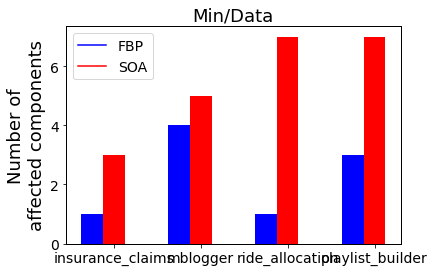

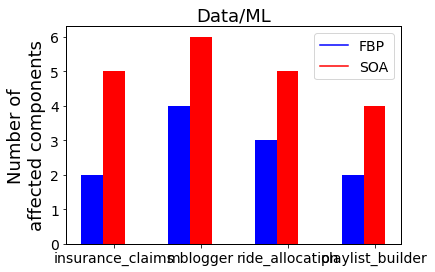

In [48]:
# min -> data

labels = list(component_diff.keys())
X = np.arange(len(apps))

def get_diff_values(from_stage, paradigm):
    values = []
    for app in component_diff:
        diff = next(x for x in component_diff[app] if x['paradigm'] == paradigm and x['from'] == from_stage)
        values.append(len(diff["changed"] if diff["changed"] is not None else []) + len(diff["new"] if diff["new"] is not None else []))
    return values

values_fbp_min_data = get_diff_values("min", "fbp")
values_soa_min_data = get_diff_values("min", "soa")
values_fbp_data_ml = get_diff_values("data", "fbp")
values_soa_data_ml = get_diff_values("data", "soa")

plt.bar(
    X, values_fbp_min_data, width=0.25,
    tick_label=labels, align='center', color='b'
);
plt.bar(
    X+0.25, values_soa_min_data, width=0.25,
    tick_label=labels, align='center', color='r'
);
plt.ylabel('Number of\naffected components');
plt.title("Min/Data")

legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]
plt.legend(handles=legend_elements, loc='best');
    
plt.show();



plt.bar(
    X, values_fbp_data_ml, width=0.25,
    tick_label=labels, align='center', color='b'
);
plt.bar(
    X+0.25, values_soa_data_ml, width=0.25,
    tick_label=labels, align='center', color='r'
);

plt.ylabel('Number of\naffected components');
plt.title("Data/ML")

legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]
plt.legend(handles=legend_elements, loc='best');

plt.show();

In [49]:
absolute_diff_metrics = [
    "Halstead Difficulty", "Maintainability Index",
    "Cyclomatic Complexity avg", "Cyclomatic Complexity p99",
    "Cognitive Complexity avg", "Cognitive Complexity p99"
]
percentage_diff_metrics = [
    "Logical Lines of Code", "Halstead Volume",
    "Halstead Effort", "Number of Words"
]

## Paper plots

In [11]:
apps = ['Insurance\nClaims', 'MBlogger', 'Ride\nAllocation', "Playlist\nBuilder"]
X = np.arange(len(apps))

# colors for colorblind
# reference: https://davidmathlogic.com/colorblind
# there are more ideas for two contrasting colors there
fbp_color = '#1A85FF'
soa_color = '#D41159'

# that's for b&w printing
# reference: https://stackoverflow.com/questions/14279344/how-can-i-add-textures-to-my-bars-and-wedges
fbp_hatch = 'x'
soa_hatch = 'o'

def single_paper_plot(values_fbp, values_soa, ylabel, title=None, filename=None):
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()

    plt.bar(
        X-0.15, values_fbp, width=0.3,
        align='center', color=fbp_color, hatch=fbp_hatch
    );
    plt.bar(
        X+0.15, values_soa, width=0.3,
        align='center', color=soa_color, hatch=soa_hatch
    );
    plt.xticks(X, apps)
    plt.ylabel(ylabel);
    if title is not None:
        plt.title(title);

    fbp_patch = matplotlib.patches.Patch(facecolor=fbp_color, hatch=fbp_hatch)
    soa_patch = matplotlib.patches.Patch(facecolor=soa_color, hatch=soa_hatch)
    plt.legend([fbp_patch, soa_patch], ['FBP', 'SOA'], loc='best');

    if filename is not None:
        plt.savefig(f"figures/{filename}.pdf");
    plt.show();


SMALL_SIZE = 14
MEDIUM_SIZE = 18
LARGE_SIZE = 22
HEAD_WIDTH = 1
HEAD_LEN = 1
plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE, labelsize=SMALL_SIZE, linewidth=1.0)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=MEDIUM_SIZE)

### Data stage

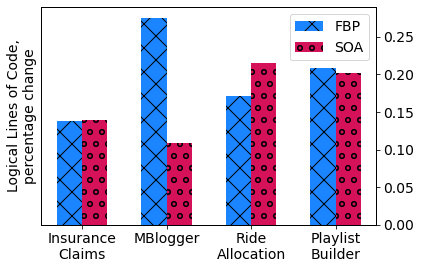

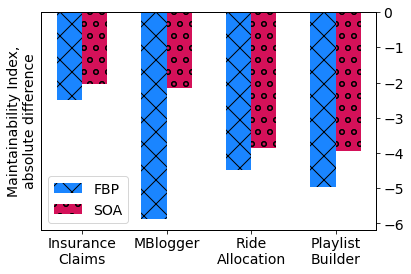

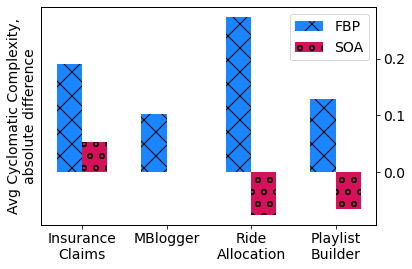

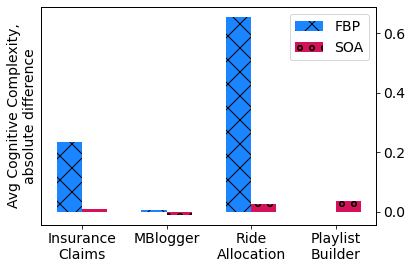

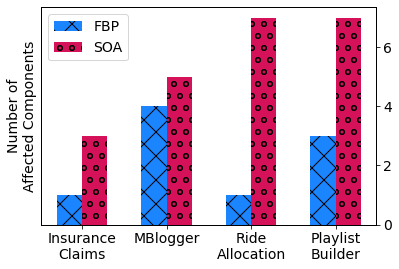

In [51]:
min_data_changes_df = all_changes_df[all_changes_df["Keys"] == "min/data"]

# question 1
metric = "Logical Lines of Code"
values_fbp = min_data_changes_df[min_data_changes_df["Paradigm"] == "fbp"][metric]
values_soa = min_data_changes_df[min_data_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Logical Lines of Code,\npercentage change",
                  filename="gqm/lloc_min_data_diff")

# question 2
metric = "Maintainability Index"
values_fbp = min_data_changes_df[min_data_changes_df["Paradigm"] == "fbp"][metric]
values_soa = min_data_changes_df[min_data_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Maintainability Index,\nabsolute difference",
                  filename="gqm/mi_min_data_diff")

# question 3
metric = "Cyclomatic Complexity avg"
values_fbp = min_data_changes_df[min_data_changes_df["Paradigm"] == "fbp"][metric]
values_soa = min_data_changes_df[min_data_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Avg Cyclomatic Complexity,\nabsolute difference",
                  filename="gqm/cyclomatic_min_data_diff")

metric = "Cognitive Complexity avg"
values_fbp = min_data_changes_df[min_data_changes_df["Paradigm"] == "fbp"][metric]
values_soa = min_data_changes_df[min_data_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Avg Cognitive Complexity,\nabsolute difference",
                  filename="gqm/cognitive_min_data_diff")

# question 4
values_fbp = get_diff_values("min", "fbp")
values_soa = get_diff_values("min", "soa")
single_paper_plot(values_fbp, values_soa, "Number of\nAffected Components",
                  filename="gqm/components_min_data_diff")

In [52]:
min_data_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
1,insurance_claims,fbp,min/data,0.138095,0.122808,0.119183,0.151300,-0.020050,-2.50,0.19022,2.0,0.232901,1.0
7,mblogger,fbp,min/data,0.275862,0.488047,0.860059,0.282810,0.500000,-5.88,0.10223,2.0,0.004808,0.0
13,ride_allocation,fbp,min/data,0.171533,0.223463,0.451884,0.207113,1.094453,-4.47,0.27290,0.0,0.653398,6.0
19,playlist_builder,fbp,min/data,0.208861,0.212279,0.253336,0.226824,0.119122,-4.96,0.12941,1.0,0.000000,0.0
4,insurance_claims,soa,min/data,0.140000,0.209862,0.411505,0.139854,1.000000,-2.03,0.05303,0.0,0.009800,0.0
10,mblogger,soa,min/data,0.108333,0.088795,0.088795,0.144711,0.000000,-2.15,0.00000,0.0,-0.009530,0.0
16,ride_allocation,soa,min/data,0.215247,0.158409,0.277145,0.204927,0.492901,-3.87,-0.07440,1.0,0.026260,0.0
22,playlist_builder,soa,min/data,0.201581,0.108873,0.102718,0.167689,-0.017813,-3.93,-0.06364,0.0,0.034946,0.0


## ML stage

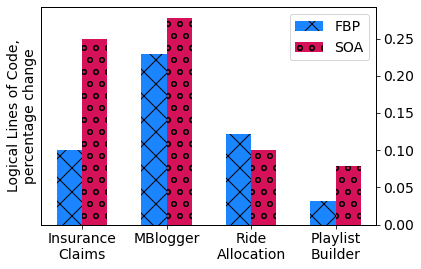

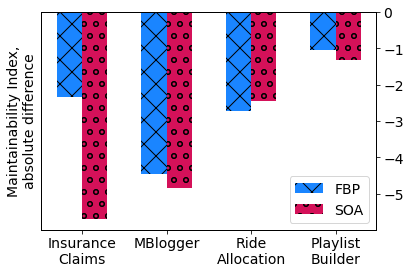

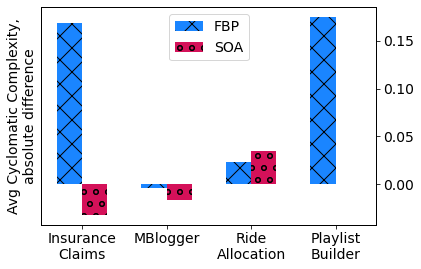

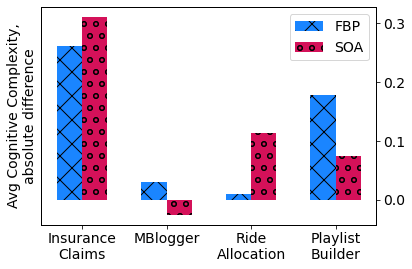

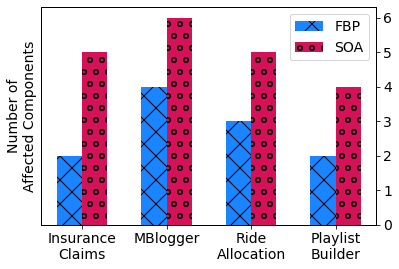

In [53]:
data_ml_changes_df = all_changes_df[all_changes_df["Keys"] == "data/ml"]

# question 1
metric = "Logical Lines of Code"
values_fbp = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "fbp"][metric]
values_soa = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Logical Lines of Code,\npercentage change",
                  filename="gqm/lloc_data_ml_diff")

# question 2
metric = "Maintainability Index"
values_fbp = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "fbp"][metric]
values_soa = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Maintainability Index,\nabsolute difference",
                  filename="gqm/mi_data_ml_diff")

# question 3
metric = "Cyclomatic Complexity avg"
values_fbp = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "fbp"][metric]
values_soa = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Avg Cyclomatic Complexity,\nabsolute difference",
                  filename="gqm/cyclomatic_data_ml_diff")

metric = "Cognitive Complexity avg"
values_fbp = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "fbp"][metric]
values_soa = data_ml_changes_df[data_ml_changes_df["Paradigm"] == "soa"][metric]
single_paper_plot(values_fbp, values_soa, "Avg Cognitive Complexity,\nabsolute difference",
                  filename="gqm/cognitive_data_ml_diff")

# question 4
values_fbp = get_diff_values("data", "fbp")
values_soa = get_diff_values("data", "soa")
single_paper_plot(values_fbp, values_soa, "Number of\nAffected Components",
                  filename="gqm/components_data_ml_diff")

In [54]:
data_ml_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
2,insurance_claims,fbp,data/ml,0.100418,-0.109376,-0.014747,0.084189,0.657738,-2.34,0.16912,-2.0,0.261776,2.0
8,mblogger,fbp,data/ml,0.229730,0.435824,0.722989,0.236311,0.500000,-4.45,-0.00395,-2.0,0.029605,1.0
14,ride_allocation,fbp,data/ml,0.121495,0.148057,0.157376,0.126516,0.056465,-2.71,0.02339,0.0,0.009760,0.0
20,playlist_builder,fbp,data/ml,0.031414,0.170650,0.370372,0.069132,0.620393,-1.05,0.17500,1.0,0.178571,1.0
5,insurance_claims,soa,data/ml,0.249123,0.457239,0.478358,0.209302,0.101449,-5.70,-0.03205,0.0,0.310710,5.0
11,mblogger,soa,data/ml,0.278195,0.337598,0.337598,0.270270,0.000000,-4.85,-0.01667,0.0,-0.025220,1.0
17,ride_allocation,soa,data/ml,0.099631,0.098153,0.212133,0.081340,0.550276,-2.45,0.03463,0.0,0.113100,0.0
23,playlist_builder,soa,data/ml,0.078947,0.040904,0.386138,0.105079,1.058511,-1.31,0.00000,0.0,0.074562,0.0


## Additional plots

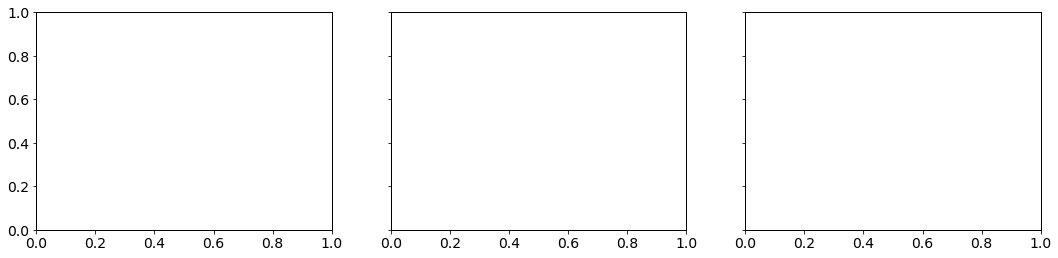

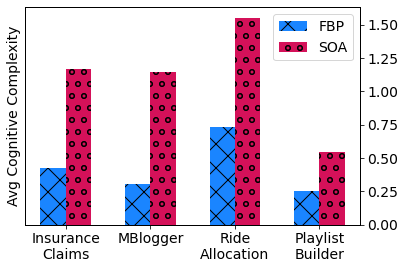

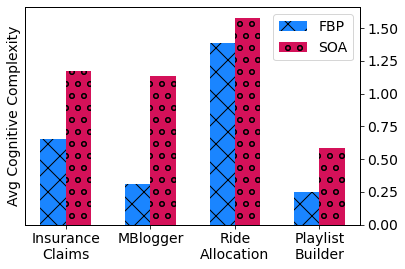

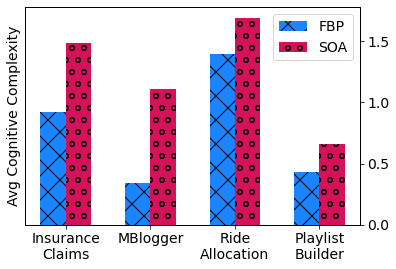

In [12]:
# absolute values for cognitive complexity
import matplotlib as mpl

original_figure_size = mpl.rcParams['figure.figsize']
new_figure_size = (original_figure_size[0] * 3, original_figure_size[1])
f, axes = plt.subplots(1, 3, sharey=True, figsize=new_figure_size)

metric = "Cognitive Complexity avg"
for i, stage in enumerate(("min", "data", 'ml')):
    values_fbp = df[df["Key"].str.startswith("fbp") & df["Key"].str.endswith(stage)][metric]
    values_soa = df[df["Key"].str.startswith("soa") & df["Key"].str.endswith(stage)][metric]
    single_paper_plot(values_fbp, values_soa, "Avg Cognitive Complexity",
                  filename=f"gqm/cognitive_{stage}_diff")
    
    # ax = axes[i]
    
    # ax.yaxis.set_tick_params(labelbottom=True)
    # ax.yaxis.tick_right()
    
    # ax.bar(
    #     X-0.15, values_fbp, width=0.3,
    #     align='center', color=fbp_color, hatch=fbp_hatch
    # );
    # ax.bar(
    #     X+0.15, values_soa, width=0.3,
    #     align='center', color=soa_color, hatch=soa_hatch
    # );
    # ax.set_xticks(X)
    # ax.set_xticklabels(apps)

    # if i == 0:
    #     ax.set_ylabel("Avg Cognitive Complexity");
    # ax.set_title(stage);

    # fbp_patch = matplotlib.patches.Patch(facecolor=fbp_color, hatch=fbp_hatch)
    # soa_patch = matplotlib.patches.Patch(facecolor=soa_color, hatch=soa_hatch)
    # ax.legend([fbp_patch, soa_patch], ['FBP', 'SOA'], loc='best');

# f.tight_layout()

# plt.savefig(f"figures/gqm/avg_cognitive_all.pdf");
# plt.show();